**Load Libraries**

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

Load Dataset

In [3]:
df = pd.read_csv(r"C:\Users\USER\Desktop\DeepTech Programme\Streamlit Projects\diabetes_prediction_dataset.csv\diabetes_prediction_dataset.csv")
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


Split Dataset For Training

In [5]:
X = df.drop(columns=["diabetes"])
y = df["diabetes"]

cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


Train Logistic Regression Model

In [6]:
from sklearn.linear_model import LogisticRegression

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first"), cat_cols)
    ]
)

log_reg = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

log_reg.fit(X_train, y_train)

y_pred = log_reg.predict_proba(X_test)[:, 1]
print("AUC:", roc_auc_score(y_test, y_pred))


AUC: 0.9624980874316941


Feature importance (absolute coefficients)

In [7]:
feature_names = (
    log_reg.named_steps["prep"]
    .get_feature_names_out()
)

coefs = log_reg.named_steps["model"].coef_[0]

importance = pd.Series(np.abs(coefs), index=feature_names)\
              .sort_values(ascending=False)

importance.head(15)


num__HbA1c_level                    2.505136
num__blood_glucose_level            1.364803
num__age                            1.026914
cat__smoking_history_current        0.722984
cat__smoking_history_ever           0.649215
cat__smoking_history_former         0.622467
num__bmi                            0.591843
cat__smoking_history_never          0.588769
cat__smoking_history_not current    0.585398
cat__gender_Male                    0.298006
num__hypertension                   0.201588
num__heart_disease                  0.146995
cat__gender_Other                   0.009127
dtype: float64

Train RandomForest Classifier

In [8]:
from sklearn.ensemble import RandomForestClassifier

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first"), cat_cols)
    ]
)

rf = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"
    ))
])

rf.fit(X_train, y_train)

rf_pred = rf.predict_proba(X_test)[:, 1]
print("AUC:", roc_auc_score(y_test, rf_pred))

AUC: 0.9674432336869174


Feature importance (absolute coefficients)

In [9]:
rf_importance = pd.Series(
    rf.named_steps["model"].feature_importances_,
    index=feature_names
).sort_values(ascending=False)

rf_importance.head(15)



num__HbA1c_level                    0.346896
num__blood_glucose_level            0.275626
num__age                            0.181513
num__bmi                            0.126293
num__hypertension                   0.024922
num__heart_disease                  0.014908
cat__gender_Male                    0.007290
cat__smoking_history_former         0.006597
cat__smoking_history_never          0.005726
cat__smoking_history_current        0.003777
cat__smoking_history_not current    0.003585
cat__smoking_history_ever           0.002856
cat__gender_Other                   0.000011
dtype: float64

Train without HbA1c & glucose

In [10]:

X_reduced = X.drop(columns=["HbA1c_level", "blood_glucose_level"])

Xtr, Xte, ytr, yte = train_test_split(
    X_reduced, y, test_size=0.2, stratify=y, random_state=42
)

rf_reduced = Pipeline([
    ("prep", ColumnTransformer([
        ("num", StandardScaler(), X_reduced.select_dtypes(exclude="object").columns),
        ("cat", OneHotEncoder(drop="first"), X_reduced.select_dtypes(include="object").columns)
    ])),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"
    ))
])

rf_reduced.fit(Xtr, ytr)
print("Reduced AUC:", roc_auc_score(yte, rf_reduced.predict_proba(Xte)[:,1]))



Reduced AUC: 0.7369508678881388


Reduced AUC ≈ 0.738
(after removing HbA1c_level and blood_glucose_level)

This confirms that No data leakage

If there were leakage, AUC would have stayed unrealistically high (≈0.90+).

In [11]:
# Save the trained Random Forest pipeline (diagnostic model)

import pickle

# Save the trained Random Forest pipeline (diagnostic model)
with open("rf_diabetes_model.pkl", "wb") as f:
    pickle.dump(rf, f)

Calibrate the  reduced model (improves probability estimates)

In [12]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve, classification_report

rf_calibrated = CalibratedClassifierCV(rf_reduced, cv=5)
rf_calibrated.fit(X_train, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=Pipeline(steps=[('prep',
                                                  ColumnTransformer(transformers=[('num',
                                                                                   StandardScaler(),
                                                                                   Index(['age', 'hypertension', 'heart_disease', 'bmi'], dtype='object')),
                                                                                  ('cat',
                                                                                   OneHotEncoder(drop='first'),
                                                                                   Index(['gender', 'smoking_history'], dtype='object'))])),
                                                 ('model',
                                                  RandomForestClassifier(class_weight='balanced',
                                                                         n_estimators=300,
                                                                         random_state=42))]))

In [13]:
# Get predicted probabilities on test set
rf_red_pred = rf_calibrated.predict_proba(X_test)[:,1]

In [14]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, rf_red_pred)

In [15]:
# Align lengths (thresholds is 1 shorter than recall)

recall_for_thresh = recall[:-1]

#Create DataFrame for easier selection

pr_df = pd.DataFrame({
    "threshold": thresholds,
    "precision": precision[:-1],
    "recall": recall_for_thresh
})

#  Select all thresholds with recall >= 0.9
candidate_thresholds = pr_df[pr_df["recall"] >= 0.9]

# Pick the largest threshold to avoid zero / extreme low
best_threshold = candidate_thresholds["threshold"].max()
print(f"Selected threshold for recall >= 0.9: {best_threshold:.3f}")

# Apply threshold to get binary predictions
y_pred_binary = (rf_red_pred >= best_threshold).astype(int)

# Classification report
print(classification_report(yte, y_pred_binary))

Selected threshold for recall >= 0.9: 0.055
              precision    recall  f1-score   support

           0       0.98      0.49      0.65     18300
           1       0.14      0.90      0.24      1700

    accuracy                           0.53     20000
   macro avg       0.56      0.70      0.45     20000
weighted avg       0.91      0.53      0.62     20000



## Screening Model Performance Summary

This reduced Random Forest model was intentionally optimized as a **screening tool** for diabetes rather than a definitive diagnostic model. In screening contexts, the primary objective is to **maximize recall (sensitivity)** to ensure that most individuals with the condition are correctly identified, even at the cost of lower precision.

### Key Results
- **Recall (Diabetes class): 0.90**
  - The model correctly identifies **90% of individuals with diabetes**, minimizing false negatives.
- **Precision (Diabetes class): 0.14**
  - A higher number of false positives is expected and acceptable in screening, as flagged individuals are referred for confirmatory testing.
- **Overall Accuracy: 0.53**
  - Accuracy is not a primary metric for screening models, especially under class imbalance.
- **AUC: 0.74**
  - Indicates reasonable discriminatory power using a reduced feature set.

### Interpretation
The model demonstrates strong sensitivity, making it suitable for **early risk detection** and **population-level screening**, particularly in low-resource or preventive healthcare settings. Individuals identified as high risk can subsequently undergo confirmatory laboratory tests (e.g., HbA1c or fasting glucose), ensuring efficient allocation of diagnostic resources.

### Conclusion
This model is **fit for purpose as a screening model**, prioritizing recall to reduce missed diabetes cases while accepting lower precision as part of a two-stage clinical workflow.


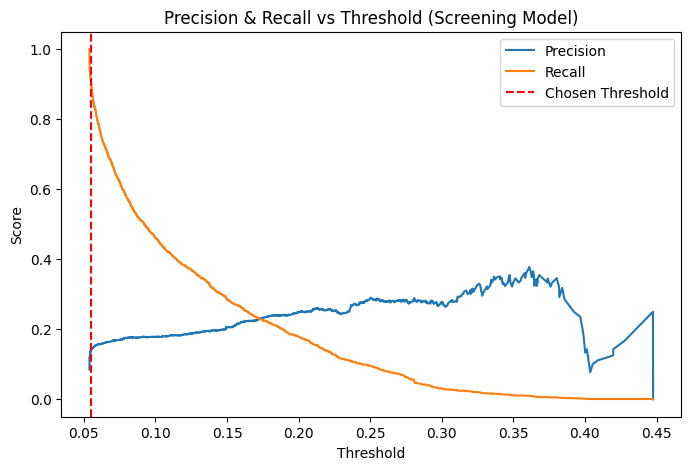

In [16]:
# Precision-Recall vs Threshold plot


import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.axvline(best_threshold, color='red', linestyle='--', label="Chosen Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold (Screening Model)")
plt.legend()
plt.show()

Save Reduced Model

In [17]:
import pickle

# Save the calibrated reduced model
with open("rf_screening_model.pkl", "wb") as f:
    pickle.dump(rf_calibrated, f)

# Save the threshold
with open("screening_threshold.pkl", "wb") as f:
    pickle.dump(best_threshold, f)

print("Screening model and threshold saved successfully!")


Screening model and threshold saved successfully!


In [19]:
import sklearn
print(sklearn.__version__)


1.6.0
